## Improve RAG Retrieval using Query Expansion 
### 1. Load Data
    - Split the Pdf data in to Chunks
### 2. Create Vector Store & Load Chunks
    - Define the vector Store and collection
    - Add the chunks to the Collection
    - Visualize the Dataset
### 3. Query Vector Store
    - Visualize Original query & Retrieved Docs
### 4. Query Expansion using Generated Answer
    - Visualize Original query, Modified query (ans) and Retrieved Docs
### 5. Query Expansion using Generated Queries
    - Visualize Original query, Generated Queries & Retieved Docs
### 6. RAG Performance

**1. Load Data**
   -Load the apple-Form-10-k.pdf file

In [38]:
from dotenv import load_dotenv
from groq import Groq
import os
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
client = Groq(api_key=groq_api_key)

In [2]:
# load the pdf file's pages
from pypdf import PdfReader
reader = PdfReader("apple-form-10-k.pdf")
number_of_pages = len(reader.pages)
print(f'No. of Pages:{number_of_pages}')

pages = [ page. extract_text().strip () for page in reader.pages]
pages = [ page for page in pages if page != '']
cnt =len(pages)
print(f'Page Count:{cnt}')

No. of Pages:63
Page Count:63


In [12]:
print(pages[0])

stocklight.com
 
>
Stocks
 
>
United States
 
Apple
 
>
Annual Reports
 
>
2023 Annual Report
Apple Annual Report 2023
Form 10-K (NASDAQ:AAPL)
Published: November 3rd, 2023
Brought to you by


**1.2. Split data into chunks** 

In [21]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=25,
    separators=["\n\n", "\n", " ", ""],
    length_function=len,
)
character_split_texts = text_splitter.split_text('\n\n'.join(pages))
print(f'Total Chunks:{len(character_split_texts)}')

Total Chunks:245


In [22]:
print({character_split_texts[20]})

{'The Company’s ability to compete successfully depends heavily on ensuring the continuing and timely introduction of innovative new products, services and\ntechnologies to the marketplace. The Company designs and develops nearly the entire solution for its products, including the hardware, operating system, numerous\nsoftware applications and related services. Principal competitive factors important to the Company include price, product and service features (including security\nfeatures), relative price and performance, product and service quality and reliability, design innovation, a strong third-party software and accessories ecosystem,\nmarketing and distribution capability, service and support, and corporate reputation.\nThe Company is focused on expanding its market opportunities related to smartphones, personal computers, tablets, wearables and accessories, and services. The'}


### 2. Create Vector store & Load chunks
**2.1 Define Vector Store and Collection**

In [13]:
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import chromadb
def create_chroma_vector_db(path:str, collection_name:str, metadata:any):
    model_name = "all-distilroberta-v1" ## 768 Dimensions
    embedding_function = SentenceTransformerEmbeddingFunction(model_name=model_name)    
    chroma_client = chromadb.PersistentClient(path=path)

    collection = chroma_client.get_or_create_collection(name=collection_name,
                                                        embedding_function=embedding_function,
                                                        metadata=metadata,
                                                       )   
    return collection

In [14]:
path= "apple_form_10k"
collection_name="apple_10k"
file_name="apple"
metadata = {
    "title":"Apple-10-k-report",
    "description":"This is the report of Apple-10-k-report",
}
new_collection = create_chroma_vector_db(path, collection_name, metadata)

In [6]:
import chromadb
path = "apple_form_10k"
chroma_client = chromadb.PersistentClient(path=path)
# get the existing chromadb  collection
new_collection = chroma_client.get_collection(name="apple_10k")


**2.2 Add Chunks to Vector DB**

In [18]:
# delete all the docs in the collection
doc_ids = new_collection.get()["ids"]
new_collection.delete(ids=doc_ids)


In [19]:
new_collection.count()

0

In [23]:

new_collection.add(documents = character_split_texts,
                   ids = [f"Split-{idx}" for idx in range(len(character_split_texts))]
                   )

In [24]:
new_collection.count()

245

**2.3 Visualize Text Chunks**

In [25]:
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm 

embeddings = new_collection.get(include=['embeddings'])['embeddings']
umap_projector = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_projector):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_projector.transform([embedding])
    return umap_embeddings

projected_dataset_embeddings = project_embeddings(embeddings, umap_projector)

c:\Maran\StudyMaterials\Git\LangChain\Retrieval-QueryExpansion-groq\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
100%|██████████| 245/245 [00:02<00:00, 95.69it/s] 


Text(0.5, 1.0, 'Embeddings of the dataset')

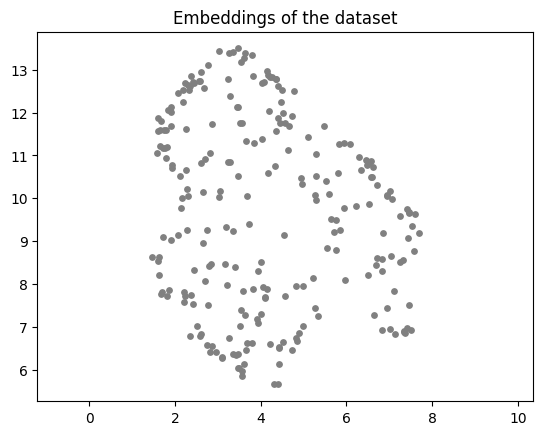

In [10]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(projected_dataset_embeddings[:,0],projected_dataset_embeddings[:,1],s=15,c="grey")
plt.gca().set_aspect('equal', 'datalim')
plt.title("Embeddings of the dataset")
# plt.axes('off')

**3.Query Vector Store**

In [26]:
# query the vector store
query = "What are the risk factors for the company?"

results = new_collection.query(query_texts=[query], n_results=5, include=["documents","embeddings"])
results.keys()

dict_keys(['ids', 'embeddings', 'documents', 'uris', 'data', 'metadatas', 'distances', 'included'])

In [27]:
retrieved_doc1 = results['documents'][0]
for doc in retrieved_doc1:
    print(doc)
    print('------------------------------')

the Company is at a relatively greater risk of being targeted because of its high proﬁle and the value of the conﬁdential information it creates, owns, manages, stores
and processes.
The Company has implemented systems and processes intended to secure its information technology systems and prevent unauthorized access to or loss of
sensitive data, and mitigate the impact of unauthorized access, including through the use of encryption and authentication technologies. As with all companies, these
security measures may not be sufficient for all eventualities and may be vulnerable to hacking, ransomware attacks, employee error, malfeasance, system error, faulty
password management or other irregularities. For example, third parties can fraudulently induce the Company’s or its vendors’ employees or customers into
disclosing usernames, passwords or other sensitive information, which can, in turn, be used for unauthorized access to the Company’s or its vendors’ systems and
--------------------

**Visualize Dataset, Query & Retrieved Docs**

In [29]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-distilroberta-v1")
retrieved_docs_embeddings = results['embeddings'][0]
original_query_embedding = model.encode([query])

In [35]:
retrieved_docs_embeddings

array([[ 0.02424209,  0.00256688, -0.0256607 , ..., -0.02590028,
         0.03372536, -0.00460018],
       [ 0.00763545,  0.00935274, -0.01189147, ..., -0.0274272 ,
         0.03205676,  0.00308822],
       [ 0.0251954 ,  0.0338137 , -0.01499031, ..., -0.02408316,
         0.02093992, -0.04106711],
       [ 0.025039  ,  0.01778993, -0.00395734, ...,  0.03351023,
         0.01815764,  0.00494384],
       [ 0.03874329,  0.07470769, -0.00976765, ..., -0.02047856,
         0.03587358, -0.02030796]])

In [36]:
projected_original_query_embedding = project_embeddings(
    original_query_embedding, 
    umap_projector
)
projected_retrieved_doc_embedding = project_embeddings(
    retrieved_docs_embeddings,
    umap_projector
)

100%|██████████| 5/5 [00:00<00:00, 98.89it/s]


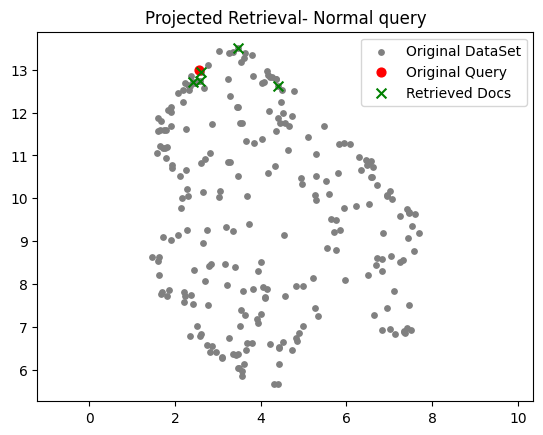

In [37]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(projected_dataset_embeddings[:,0],projected_dataset_embeddings[:,1], s=15, c="grey",label="Original DataSet")
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=40, c="red", label="Original Query")
plt.scatter(projected_retrieved_doc_embedding[:,0],projected_retrieved_doc_embedding[:,1],s=50, marker ="x", c="green", label="Retrieved Docs")
plt.gca().set_aspect('equal', 'datalim')
plt.title("Projected Retrieval- Normal query")
plt.legend(loc="best")
# plt.axes('off');

**4.Query Expansion with Generated Answer**

In [39]:
def generate_answer(query, model ="llama-3.1-70b-versatile"):
    messages = [
        {"role": "system", "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report."},
        {"role": "user", "content": query},
    ]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0.7,
        max_tokens=1024,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    content = response.choices[0].message.content
    return content

generate_answer = generate_answer(query)
print(generate_answer)

**Risk Factors**

The company operates in a rapidly changing and competitive environment, and as such, is subject to a variety of risks and uncertainties that could impact its financial condition, results of operations, and ability to execute its business strategy. The following are some of the key risk factors that could affect the company's performance:

1. **Market and Competitive Risks**: The company operates in highly competitive markets, and an increase in competition could lead to a decline in market share, revenue, and profitability.
2. **Regulatory Risks**: Changes in laws, regulations, or industry standards could affect the company's ability to operate its business, increase costs, and reduce revenue.
3. **Economic Risks**: Economic downturns, recession, or other macroeconomic factors could impact demand for the company's products and services, leading to reduced revenue and profitability.
4. **Operational Risks**: Disruptions to the company's supply chain, manufacturing proc

In [40]:
joint_query = f"{query}\n\n{generate_answer}"
print(joint_query)

What are the risk factors for the company?

**Risk Factors**

The company operates in a rapidly changing and competitive environment, and as such, is subject to a variety of risks and uncertainties that could impact its financial condition, results of operations, and ability to execute its business strategy. The following are some of the key risk factors that could affect the company's performance:

1. **Market and Competitive Risks**: The company operates in highly competitive markets, and an increase in competition could lead to a decline in market share, revenue, and profitability.
2. **Regulatory Risks**: Changes in laws, regulations, or industry standards could affect the company's ability to operate its business, increase costs, and reduce revenue.
3. **Economic Risks**: Economic downturns, recession, or other macroeconomic factors could impact demand for the company's products and services, leading to reduced revenue and profitability.
4. **Operational Risks**: Disruptions to th

In [ ]:
results = new_collection.query(query_texts=[joint_query],
                               n_results=5,
                               include=['documents', 'embeddings'])
retrieved_doc2 = results['documents'][0]
for doc in retrieved_doc2:
    print(doc)
    print("---------------------------------------------------")

Financial Risks
The Company expects its quarterly net sales and results of operations to fluctuate.
The Company’s proﬁt margins vary across its products, services, geographic segments and distribution channels. For example, the gross margins on the Company’s
products and services vary signiﬁcantly and can change over time. The Company’s gross margins are subject to volatility and downward pressure due to a variety of
factors, including: continued industry-wide global product pricing pressures and product pricing actions that the Company may take in response to such pressures;
increased competition; the Company’s ability to effectively stimulate demand for certain of its products and services; compressed product life cycles; supply shortages;
potential increases in the cost of components, outside manufacturing services, and developing, acquiring and delivering content for the Company’s services; the
------------------------------------
Company’s ability to manage product quality and war

**Visualize Dataset, query & Retrieved Docs**

In [42]:
retrieved_docs_embeddings = results['embeddings'][0]
original_query_embedding = model.encode([query])
joint_query_embedding = model.encode([joint_query])

projected_original_query_embedding = project_embeddings(
    original_query_embedding, 
    umap_projector
)
projected_retrieved_doc_embedding = project_embeddings(
    retrieved_docs_embeddings,
    umap_projector
)
projected_joint_query_embedding = project_embeddings(
    joint_query_embedding,
    umap_projector
)

100%|██████████| 1/1 [00:00<00:00, 29.21it/s]


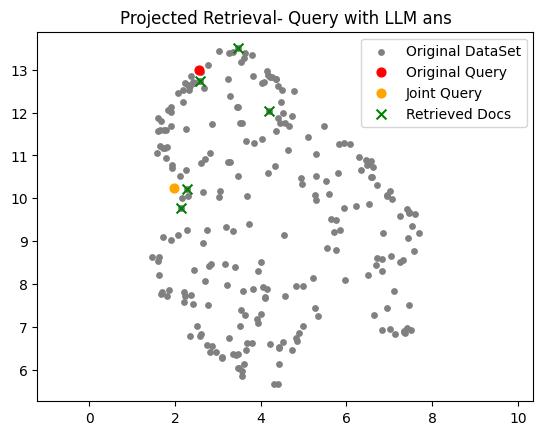

In [43]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:,0],projected_dataset_embeddings[:,1], s=15, c="grey",label="Original DataSet")
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=40, c="red", label="Original Query")
plt.scatter(projected_joint_query_embedding[:,0], projected_joint_query_embedding[:,1], s=40, c="orange", label="Joint Query")
plt.scatter(projected_retrieved_doc_embedding[:,0],projected_retrieved_doc_embedding[:,1],s=50, marker ="x", c="green", label="Retrieved Docs")
plt.gca().set_aspect('equal', 'datalim')
plt.title("Projected Retrieval- Query with LLM ans")
plt.legend(loc="best")

**5. Query Expansion using Generated Queries**

In [46]:
def generate_queries(query, model ="llama-3.1-70b-versatile"):
    messages = [
        {"role": "system",
         "content": """You are a helpful expert financial assistant. Your users are asking questions about an annual report.
          Suggest up to five additional related questions to help them find the information they need, for the provided question.
          Suggest only short questions without compound sentences. Suggest variety of questions that coverr different aspects of the topic.
          Make sure they are complete questions, and that they are related to the original question
          Output one question per line. Do not number the questions"""},
        {"role": "user", "content": query},
    ]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [48]:
augmented_queries =generate_queries(query)
augmented_queries = [ query for query in augmented_queries if query.strip()]

for query in augmented_queries:
    print(query)    

What are the main risks identified by the company?
How does the company assess and prioritize risks?
What are the key risk mitigation strategies employed?
Are there any significant changes to the risk management framework?
How does the company monitor and review its risk management framework?


In [49]:
queries = [query] + augmented_queries
results =  new_collection.query(
    query_texts=queries,
    n_results=5,
    include=["documents",'embeddings']
)
retrived_docs3 = results['documents']

#Re Duplicate the retrieved docs
unique_docs = set()
for doc_list in retrived_docs3:
    for doc in doc_list:
        unique_docs.add(doc)
        
len(queries),len(unique_docs)

(6, 13)

**Visualize Dataset, Query & Retrieved Docs Embeddings**
